In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pytz
from datetime import datetime

In [2]:
# load the EVChargingStationUsage.csv into dataframe

df_main = pd.read_csv('./EVChargingStationUsage.csv')

C:\Users\DELL\AppData\Local\Temp\ipykernel_19140\2605640784.py:3: DtypeWarning: Columns (29,30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df_main = pd.read_csv('./EVChargingStationUsage.csv')


In [3]:
df_main.columns

Index(['Station Name', 'MAC Address', 'Org Name', 'Start Date',
       'Start Time Zone', 'End Date', 'End Time Zone',
       'Transaction Date (Pacific Time)', 'Total Duration (hh:mm:ss)',
       'Charging Time (hh:mm:ss)', 'Energy (kWh)', 'GHG Savings (kg)',
       'Gasoline Savings (gallons)', 'Port Type', 'Port Number', 'Plug Type',
       'EVSE ID', 'Address 1', 'City', 'State/Province', 'Postal Code',
       'Country', 'Latitude', 'Longitude', 'Currency', 'Fee', 'Ended By',
       'Plug In Event Id', 'Driver Postal Code', 'User ID', 'County',
       'System S/N', 'Model Number'],
      dtype='object')

In [4]:
df_processed = df_main[['Station Name', 'Start Date', 'Start Time Zone', 'Total Duration (hh:mm:ss)', 'Charging Time (hh:mm:ss)', 'Plug Type', 'Port Type']]

df_processed['Station Name'] = df_processed['Station Name'].str.replace(' ', '')

C:\Users\DELL\AppData\Local\Temp\ipykernel_19140\1180463022.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_processed['Station Name'] = df_processed['Station Name'].str.replace(' ', '')


In [5]:
del df_main

In [6]:
# Convert the 'Start Date' column to datetime format and into common Time Xone of UTC

def convert_to_utc(row):
    try:
        dt = datetime.strptime(row['Start Date'], "%m/%d/%Y %H:%M")
    except ValueError:
        dt = datetime.strptime(row['Start Date'], "%m-%d-%Y %H:%M")

    tz = (
        pytz.timezone('America/Los_Angeles')
        if row['Start Time Zone'] in ('PDT', 'PST')
        else pytz.timezone('UTC')
    )

    return tz.localize(dt).astimezone(pytz.utc)

# Apply the conversion function and create a new column 'datetime_utc'
df_processed['Start Date'] = df_processed.apply(convert_to_utc, axis=1)

# Drop the 'Start Time Zone' column
df_processed.drop(columns=['Start Time Zone'], inplace=True)

In [7]:
df_processed['Start Month'] = df_processed['Start Date'].dt.month

df_processed['Day of Week'] = df_processed['Start Date'].dt.day_name()

df_processed['Minutes Passed From The Day'] = df_processed['Start Date'].dt.hour * 60 + df_processed['Start Date'].dt.minute

df_processed['Waiting Time'] = df_processed['Total Duration (hh:mm:ss)'].str.split(':').apply(lambda x: int(x[0]) * 60 + int(x[1])) - df_processed['Charging Time (hh:mm:ss)'].str.split(':').apply(lambda x: int(x[0]) * 60 + int(x[1]))

df_processed = df_processed[df_processed['Waiting Time'] >= 0]

In [8]:
# Remove row in which Plug Type is not J1772
df_processed = df_processed[df_processed['Plug Type'] == 'J1772']

df_processed.drop(columns=['Start Date', 'Total Duration (hh:mm:ss)', 'Charging Time (hh:mm:ss)', 'Plug Type', 'Port Type'], inplace=True)

In [9]:
# Doing labelling for each station

df_processed['Station Name'] = df_processed['Station Name'].astype('category').cat.codes

In [10]:
# Doing one hot encoding month

df_processed = pd.concat([df_processed, pd.get_dummies(df_processed['Start Month'], prefix='Month', drop_first=True)], axis=1)

df_processed.drop(columns=['Start Month'], inplace=True)

In [11]:
# Doing one hot encoding day of week

df_processed = pd.concat([df_processed, pd.get_dummies(df_processed['Day of Week'], prefix='', drop_first=True)], axis=1)

df_processed.drop(columns=['Day of Week'], inplace=True)

In [12]:
#If minutes passed from the day is greater than or equal to 301 and less than or equal to 720 then assign 1, if greater than or equal to 721 and less than or equal to 1080 then assign 2, otherwise assign 3

df_processed['Category of Start Time'] = df_processed['Minutes Passed From The Day'].apply(lambda x: 1 if x >= 301 and x <= 720 else 2 if x >= 721 and x <= 1080 else 3)

df_processed.drop(columns=['Minutes Passed From The Day'], inplace=True)

# Perform one-hot encoding
df_processed['Morning'] = df_processed['Category of Start Time'].apply(lambda x: 1 if x == 1 else 0)
df_processed['Mid Time'] = df_processed['Category of Start Time'].apply(lambda x: 1 if x == 2 else 0)

# Drop the original column if needed
df_processed = df_processed.drop('Category of Start Time', axis=1)

<Axes: xlabel='Waiting Time'>

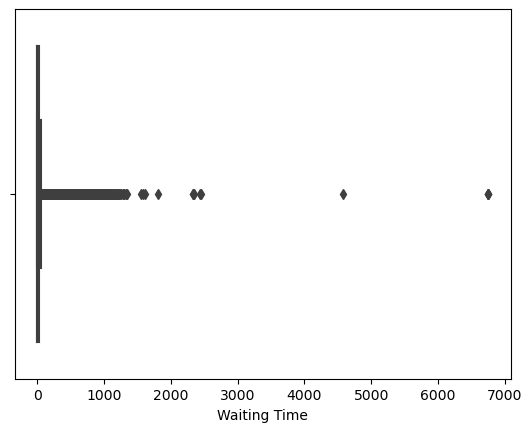

In [13]:
# Plot the box plot of waiting time

sns.boxplot(x=df_processed['Waiting Time'])

In [14]:
# Remove the rows which are outlier in Waiting Time column which is lesser than Q1 - 1.5 * IQR or greater than Q3 + 1.5 * IQR 

Q1 = df_processed['Waiting Time'].quantile(0.25)
Q3 = df_processed['Waiting Time'].quantile(0.75)
IQR = Q3 - Q1

df_processed = df_processed[(df_processed['Waiting Time'] >= Q1 - 1.5 * IQR) & (df_processed['Waiting Time'] <= Q3 + 1.5 * IQR)]    

In [15]:
# Define column Waiting Time Bucket, assign 0 if Waiting Time is less than 10 minutes, 1 if Waiting Time is less than 20 minutes, and so on

df_processed['Waiting Time Bucket'] = (df_processed['Waiting Time']/10).astype(int)

df_processed.drop(columns=['Waiting Time'], inplace=True)

In [16]:
df_processed.head()

,Station Name,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,...,Month_12,_Monday,_Saturday,_Sunday,_Thursday,_Tuesday,_Wednesday,Morning,Mid Time,Waiting Time Bucket
1,11,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
2,11,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,11,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,11,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,2
7,11,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [17]:
# Now set X as column apart from waiting time and Y as waiting time

X = df_processed.drop(columns=['Waiting Time Bucket'])
Y = df_processed['Waiting Time Bucket']

In [18]:
# Split the data into training and testing set

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

print(X_train.shape, Y_train.shape)

(176990, 20) (176990,)


In [19]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

In [20]:

# Train the model using Linear Regression

regressor = LinearRegression()

regressor.fit(X_train, Y_train)

# Calculate the training accuracy

print(regressor.score(X_train, Y_train))

# Calculate the testing accuracy

print(regressor.score(X_test, Y_test))

del regressor

0.013863964788760286
0.014496707133514919


In [21]:

# Train the model using SGD Regressor

regressor = SGDRegressor()

regressor.fit(X_train, Y_train)

# Calculate the training accuracy

print(regressor.score(X_train, Y_train))

# Calculate the testing accuracy

print(regressor.score(X_test, Y_test))

del regressor

0.010884734384877026
0.01096248125805055


In [22]:
# Make the model using Decision Tree Regressor

regressor = DecisionTreeRegressor()

regressor.fit(X_train, Y_train)

# Calculate the training accuracy

print(regressor.score(X_train, Y_train))

# Calculate the testing accuracy

print(regressor.score(X_test, Y_test))

del regressor

0.06077918033232965
-0.015237338202225503


In [23]:
# Make the model using Random Forest Regressor

regressor = RandomForestRegressor()

regressor.fit(X_train, Y_train)

# Calculate the training accuracy

print(regressor.score(X_train, Y_train))

# Calculate the testing accuracy

print(regressor.score(X_test, Y_test))

del regressor

0.05980944493748053
-0.010320269327621645


In [24]:
# Make the model using Gradient Boosting Regressor

regressor = GradientBoostingRegressor()

regressor.fit(X_train, Y_train)

# Calculate the training accuracy

print(regressor.score(X_train, Y_train))

# Calculate the testing accuracy

print(regressor.score(X_test, Y_test))

del regressor

0.021080266544362458
0.01957043659985891


In [25]:

# Make the model using XGB Regressor

regressor = XGBRegressor()

regressor.fit(X_train, Y_train)

# Calculate the training accuracy

print(regressor.score(X_train, Y_train))

# Calculate the testing accuracy

print(regressor.score(X_test, Y_test))

del regressor

0.039376876049945664
0.016039130037418414


In [26]:


# Make the model using Polynomial Regression

poly_reg = PolynomialFeatures(degree=2)

X_poly = poly_reg.fit_transform(X_train)

regressor = LinearRegression()

regressor.fit(X_poly, Y_train)

# Calculate the training accuracy

print(regressor.score(X_poly, Y_train))

# Calculate the testing accuracy

print(regressor.score(poly_reg.fit_transform(X_test), Y_test))

del regressor
del poly_reg
del X_poly

0.015762677125041757
0.014616390141386826


In [27]:

# Add L2 regularization

poly_reg = PolynomialFeatures(degree=2)

X_poly = poly_reg.fit_transform(X_train)

ridge_reg = Ridge(alpha=0.1)

ridge_reg.fit(X_poly, Y_train)

# Calculate the training accuracy

print(ridge_reg.score(X_poly, Y_train))

# Calculate the testing accuracy

print(ridge_reg.score(poly_reg.fit_transform(X_test), Y_test))

del X_poly
del poly_reg
del ridge_reg

0.01576269468215552
0.014618383204689223


In [28]:
# Make a model using elastic net

poly_reg = PolynomialFeatures(degree=2)

X_poly = poly_reg.fit_transform(X_train)

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)

elastic_net.fit(X_poly, Y_train)

# Calculate the training accuracy

print(elastic_net.score(X_poly, Y_train))

# Calculate the testing accuracy

print(elastic_net.score(poly_reg.fit_transform(X_test), Y_test))

del X_poly
del poly_reg
del elastic_net

0.008098584809741682
0.0089407061522635
